![Crisp](img/logo.png)
# <img src="img/Blueprints-Extreme Weather Impact.png" alt="icon" width="40"/>  Extreme Weather Analysis

[![Open in Colab](https://img.shields.io/badge/Open%20in-Colab-orange?logo=google-colab&style=for-the-badge)](https://colab.research.google.com/github/gocrisp/blueprints/blob/main/notebooks/crisp_extreme_weather_analysis.ipynb)
[![Open in Vertex AI](https://img.shields.io/badge/Open%20in-Vertex%20AI%20Workbench-brightgreen?logo=google-cloud&style=for-the-badge)](https://console.cloud.google.com/vertex-ai/notebooks/deploy-notebook?download_url=https://raw.githubusercontent.com/gocrisp/blueprints/blob/main/notebooks/crisp_extreme_weather_analysis.ipynb)
[![Open in Databricks](https://img.shields.io/badge/Try-databricks-red?logo=databricks&style=for-the-badge)](https://www.databricks.com/try-databricks)
[![View on GitHub](https://img.shields.io/badge/View%20on-GitHub-lightgrey?logo=github&style=for-the-badge)](https://github.com/gocrisp/blueprints/blob/main/notebooks/extreme_weather_analysis.ipynb)

> To deploy a notebook in Databricks:
> 1. Open your workspace and navigate to the folder where you want to import the notebook.
> 2. Click the triple-dot icon (next to the Share button).
> 3. Select **Import**, then choose **URL** as the import method.
> 4. Paste the notebook's URL, then click **Import** to complete the process.

## Introduction
This notebook analyzes the impact of extreme weather events on sales and inventory. It combines retail sales data with publicly available extreme weather information to identify affected areas, measure category impacts, and generate actionable insights.
 
Analysis steps:
1. Load and prepare sales and inventory data
2. Gather and process extreme weather event data
3. Map affected geographic areas
4. Analyze sales patterns before, during, and after events
5. Examine inventory changes and develop recommendations

## Set the required environment variables

In [1]:
import os

os.environ["ACCOUNT_ID"] = "999999"
# os.environ["CONNECTOR_ID"] = "7240"
retailer = "target"

### Run Crisp common

This notebook uses the [crisp_common.ipynb](./crisp_common.ipynb) notebook to load the common functions and variables that are used across Crisp notebooks.

In [ ]:
if not os.path.exists("crisp_common.ipynb"):
    print("Downloading crisp_common.ipynb")
    !wget https://raw.githubusercontent.com/gocrisp/blueprints/main/notebooks/crisp_common.ipynb -O crisp_common.ipynb
else:
    print("crisp_common.ipynb already exists")

%run crisp_common.ipynb

## Import globally-used dependencies

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from IPython.display import display

### Load the data from BigQuery
Here we'll load our sales and inventory data from BigQuery. The data includes store information, product details, sales quantities, and inventory levels. We'll also set the date range for our analysis to focus on relevant time periods around extreme weather events.

In [4]:
# Define table names for BigQuery queries
dim_product = "exp_harmonized_retailer_dim_product"
dim_store = "exp_harmonized_retailer_dim_store"
fact_sales = "exp_harmonized_retailer_fact_sales"
fact_inventory = "exp_harmonized_retailer_fact_inventory_store"
src_project = project
src_dataset = dataset

# Set date range for analysis
start_date = pd.to_datetime("2024-01-01")
end_date = pd.to_datetime("2024-12-31")
start_date_sql = start_date.strftime("'%Y-%m-%d'")
end_date_sql = end_date.strftime("'%Y-%m-%d'")

In [5]:
%%load sales_inventory_df
WITH
  stores AS (
  SELECT
    store_id,
    store_zip,
    store_state,
    store_latitude,
    store_longitude
  FROM
    `{src_project}`.`{src_dataset}`.`{dim_store}`
  WHERE
    retailer = '{retailer}' ),
  fact_sales AS(
  SELECT
    date_key,
    store_id,
    product_id,
    SUM(sales_quantity) AS sales_quantity
  FROM
    `{src_project}`.`{src_dataset}`.`{fact_sales}`
  WHERE
    retailer = '{retailer}'
    AND CAST(date_key AS DATE) BETWEEN {start_date_sql}
    AND {end_date_sql}
  GROUP BY
    1,
    2,
    3 ),
  fact_inventory AS(
  SELECT
    date_key,
    store_id,
    product_id,
    SUM(on_hand_quantity) AS on_hand_quantity
  FROM
    `{src_project}`.`{src_dataset}`.`{fact_inventory}`
  WHERE
    retailer = '{retailer}'
    AND CAST(date_key AS DATE) BETWEEN {start_date_sql}
    AND {end_date_sql}
  GROUP BY
    1,
    2,
    3 ),
  products AS (
  SELECT
    product_id,
    product,
    product_category,
    product_sub_category
  FROM
    `{src_project}`.`{src_dataset}`.`{dim_product}`
  WHERE
    retailer = '{retailer}' )
SELECT
  s.date_key,
  s.store_id,
  st.store_zip,
  st.store_state,
  st.store_latitude,
  st.store_longitude,
  --s.product_id,
  --p.product,
  p.product_category,
  --p.product_sub_category,
  SUM(s.sales_quantity) AS sales_quantity,
  SUM(i.on_hand_quantity) AS on_hand_quantity
FROM
  fact_sales s
LEFT JOIN
  fact_inventory i
USING
  (date_key,
    store_id,
    product_id)
JOIN
  stores st
ON
  s.store_id = st.store_id
JOIN
  products p
ON
  s.product_id = p.product_id
GROUP BY
  ALL

,date_key,store_id,store_zip,store_state,store_latitude,store_longitude,product_category,sales_quantity,on_hand_quantity
0,2024-12-12,2474722301629374,11373,NY,40.746944000,-73.883664500,TV & Audio,24,128
1,2024-05-30,2474722301629374,11373,NY,40.746944000,-73.883664500,TV & Audio,23,90
2,2024-03-03,2474722301629374,11373,NY,40.746944000,-73.883664500,TV & Audio,21,126
3,2024-07-02,2474722301629374,11373,NY,40.746944000,-73.883664500,Wearables,8,22
4,2024-04-16,2474722301629374,11373,NY,40.746944000,-73.883664500,TV & Audio,23,122
...,...,...,...,...,...,...,...,...,...
387625,2024-06-07,994991929642472607,06451,CT,41.553195100,-72.815913000,Accessories,13,106
387626,2024-11-07,994991929642472607,06451,CT,41.553195100,-72.815913000,Wearables,9,49
387627,2024-12-22,994991929642472607,06451,CT,41.553195100,-72.815913000,Accessories,13,94
387628,2024-09-26,994991929642472607,06451,CT,41.553195100,-72.815913000,Accessories,6,34


## Integrate weather event data
Next, we'll gather information about extreme weather events from public sources. We'll match this data with our sales information by mapping store locations to affected areas using ZIP code and county information. This geographic matching allows us to identify which stores were impacted by specific weather events.

In [6]:
# Load and process FEMA disaster declarations data
# Federal Emergency Management Agency (FEMA), OpenFEMA Dataset: Disaster Declarations Summaries - v2.
# Retrieved from https://www.fema.gov/openfema-data-page/disaster-declarations-summaries-v2.
# This product uses the FEMA OpenFEMA API,
# but is not endorsed by FEMA. The Federal Government or FEMA cannot vouch for
# the data or analyses derived from these data after the data have been retrieved
# from the Agency's website(s).
fema_disasters_url = (
    "https://www.fema.gov/api/open/v2/DisasterDeclarationsSummaries.csv"
)

df_disasters = pd.read_csv(fema_disasters_url, dtype="str")
df_disasters = df_disasters[
    [
        "state",
        "fyDeclared",
        "incidentType",
        "declarationTitle",
        "incidentBeginDate",
        "incidentEndDate",
        "disasterNumber",
        "fipsStateCode",
        "fipsCountyCode",
    ]
]

# Create FIPS code and convert dates to proper format
df_disasters["fipsCode"] = (
    df_disasters["fipsStateCode"] + df_disasters["fipsCountyCode"]
)
df_disasters["incidentBeginDate"] = pd.to_datetime(
    df_disasters["incidentBeginDate"]
).dt.tz_localize(None)
df_disasters["incidentEndDate"] = pd.to_datetime(
    df_disasters["incidentEndDate"]
).dt.tz_localize(None)

# Filter to disasters after analysis start date
df_disasters = df_disasters[df_disasters["incidentBeginDate"] >= start_date]
df_disasters

,state,fyDeclared,incidentType,declarationTitle,incidentBeginDate,incidentEndDate,disasterNumber,fipsStateCode,fipsCountyCode,fipsCode
0,OR,2024,Fire,LEE FALLS FIRE,2024-08-08,NaT,5529,41,067,41067
1,OR,2024,Fire,ELK LANE FIRE,2024-08-04,NaT,5528,41,031,41031
2,OR,2024,Fire,MILE MARKER 132 FIRE,2024-08-02,NaT,5527,41,017,41017
7,WA,2024,Fire,RETREAT FIRE,2024-07-23,NaT,5521,53,077,53077
8,ID,2024,Fire,GWEN FIRE,2024-07-25,NaT,5520,16,000,16000
...,...,...,...,...,...,...,...,...,...,...
63761,FL,2024,Tropical Storm,TROPICAL STORM DEBBY,2024-08-01,2024-08-27,3605,12,131,12131
63762,FL,2024,Tropical Storm,TROPICAL STORM DEBBY,2024-08-01,2024-08-27,3605,12,133,12133
63763,CT,2024,Severe Storm,"SEVERE STORMS, FLOODING, AND A POTENTIAL DAM B...",2024-01-10,2024-01-13,3604,09,000,09000
63764,CT,2024,Severe Storm,"SEVERE STORMS, FLOODING, AND A POTENTIAL DAM B...",2024-01-10,2024-01-13,3604,09,000,09000


In [ ]:
# Load ZIP code to county FIPS code mapping from Census Bureau
# Source:
# https://www.census.gov/geographies/reference-files/time-series/geo/relationship-files.2020.html#zcta
# https://www2.census.gov/geo/docs/maps-data/data/rel2020/zcta520/tab20_zcta520_county20_natl.txt
!wget https://www2.census.gov/geo/docs/maps-data/data/rel2020/zcta520/tab20_zcta520_county20_natl.txt
zip_county_url = "./tab20_zcta520_county20_natl.txt"
df_zip_county = pd.read_csv(
    zip_county_url,
    sep="|",
    dtype=str,
    usecols=["GEOID_ZCTA5_20", "NAMELSAD_COUNTY_20", "GEOID_COUNTY_20"],
)
df_zip_county

In [8]:
# Map disasters to zip codes by matching county FIPS codes
df_disasters_zip = pd.merge(
    df_disasters,
    df_zip_county,
    left_on="fipsCode",
    right_on="GEOID_COUNTY_20",
    how="inner",
)

# Clean and standardize the dataset
df_disasters_zip = (
    df_disasters_zip.drop("GEOID_COUNTY_20", axis=1)
    .rename(columns={"GEOID_ZCTA5_20": "zipCode"})
    .sort_values(["incidentBeginDate", "zipCode"])
    .dropna(subset=["zipCode"])
    .drop_duplicates(subset=["disasterNumber", "zipCode"])
)

df_disasters_zip

,state,fyDeclared,incidentType,declarationTitle,incidentBeginDate,incidentEndDate,disasterNumber,fipsStateCode,fipsCountyCode,fipsCode,zipCode,NAMELSAD_COUNTY_20
6917,WA,2024,Severe Storm,"SEVERE WINTER STORMS, STRAIGHT-LINE WINDS, FLO...",2024-01-05,2024-01-29,4775,53,033,53033,98001,King County
6918,WA,2024,Severe Storm,"SEVERE WINTER STORMS, STRAIGHT-LINE WINDS, FLO...",2024-01-05,2024-01-29,4775,53,033,53033,98002,King County
6919,WA,2024,Severe Storm,"SEVERE WINTER STORMS, STRAIGHT-LINE WINDS, FLO...",2024-01-05,2024-01-29,4775,53,033,53033,98003,King County
6920,WA,2024,Severe Storm,"SEVERE WINTER STORMS, STRAIGHT-LINE WINDS, FLO...",2024-01-05,2024-01-29,4775,53,033,53033,98004,King County
6921,WA,2024,Severe Storm,"SEVERE WINTER STORMS, STRAIGHT-LINE WINDS, FLO...",2024-01-05,2024-01-29,4775,53,033,53033,98005,King County
...,...,...,...,...,...,...,...,...,...,...,...,...
10568,NJ,2025,Fire,JONES ROAD FIRE,2025-04-22,NaT,5581,34,029,34029,08753,Ocean County
10569,NJ,2025,Fire,JONES ROAD FIRE,2025-04-22,NaT,5581,34,029,34029,08755,Ocean County
10570,NJ,2025,Fire,JONES ROAD FIRE,2025-04-22,NaT,5581,34,029,34029,08757,Ocean County
10571,NJ,2025,Fire,JONES ROAD FIRE,2025-04-22,NaT,5581,34,029,34029,08758,Ocean County


## Geographical impact visualization

This function creates an interactive map visualization showing the concentration of affected stores during extreme weather events. The heatmap intensity represents areas with higher densities of impacted retail locations.

In [9]:
def visualize_disaster_impact(disaster_data):
    """
    Creates a heatmap visualization of store locations affected by disasters.
    Centers the map on the mean location of affected stores, or defaults to US center.
    """
    # Get unique store locations
    store_locations = (
        disaster_data[["store_latitude", "store_longitude", "store_zip", "store_state"]]
        .drop_duplicates()
        .copy()
    )

    # Center map on mean store location or default to US center coordinates
    center_lat = store_locations["store_latitude"].mean()
    center_lon = store_locations["store_longitude"].mean()

    if pd.isna(center_lat) or pd.isna(center_lon):
        center_lat, center_lon = 37.0902, -95.7129  # US center coordinates

    impact_map = folium.Map(location=[center_lat, center_lon], zoom_start=5)

    # Create heatmap from valid store coordinates
    heat_data = [
        [row["store_latitude"], row["store_longitude"]]
        for _, row in store_locations.iterrows()
        if not pd.isna(row["store_latitude"]) and not pd.isna(row["store_longitude"])
    ]

    if heat_data:
        HeatMap(heat_data).add_to(impact_map)

    return impact_map

## Analysis framework
The following functions create our analytical framework. They help us identify impacted areas, measure sales changes relative to control regions, and calculate the precise impact across different product categories. This methodology uses a difference-in-difference approach, which compares sales over time between affected and unaffected stores, to isolate the effect of weather events from regular sales patterns.

In [10]:
def analyze_disaster_impact(disaster_title="HURRICANE HELENE"):
    """
    Analyzes sales data for stores impacted by a specific disaster event.

    Args:
        disaster_title (str): Title of the disaster event to analyze

    Returns:
        dict: Contains filtered disaster data, sales data for impacted and control stores,
              impacted zip codes, and median incident dates. Returns None if no data found.
    """
    # Filter disaster data for the specified event
    disaster_data = df_disasters_zip[
        df_disasters_zip["declarationTitle"] == disaster_title
    ]

    if disaster_data.empty:
        print(f"No data found for {disaster_title}")
        return None

    impacted_zips = disaster_data["zipCode"].unique()

    # Prepare sales data by converting dates and splitting into impacted vs control groups
    sales_inventory_df["date_key"] = pd.to_datetime(sales_inventory_df["date_key"])
    impacted_sales = sales_inventory_df[
        sales_inventory_df["store_zip"].isin(impacted_zips)
    ].copy()
    control_sales = sales_inventory_df[
        ~sales_inventory_df["store_zip"].isin(impacted_zips)
    ].copy()

    # Calculate disaster timeframe using median start date and a 7-day window
    incident_dates = disaster_data[
        ["incidentBeginDate", "incidentEndDate"]
    ].drop_duplicates()
    median_start = pd.to_datetime(incident_dates["incidentBeginDate"].median())
    median_end = median_start + pd.Timedelta(days=7)

    return {
        "disaster_data": disaster_data,
        "impacted_sales": impacted_sales,
        "control_sales": control_sales,
        "impacted_zips": impacted_zips,
        "median_start": median_start,
        "median_end": median_end,
    }

In [11]:
def analyze_category_impact(impact_data, days_before=7, days_after=7, baseline_days=14):
    """
    Analyzes the impact of a disaster event on product categories by comparing sales
    before, during, and after the event against a baseline period.

    Args:
        impact_data (dict): Dictionary containing disaster impact data
        days_before (int): Number of days before the event to analyze
        days_after (int): Number of days after the event to analyze
        baseline_days (int): Number of days to use for baseline calculation

    Returns:
        DataFrame: Contains category impact metrics including difference-in-difference analysis
    """
    # Extract data from the impact_data dictionary
    impacted_sales = impact_data["impacted_sales"]
    control_sales = impact_data["control_sales"]
    median_start = impact_data["median_start"]
    median_end = impact_data["median_end"]

    # Define analysis time periods
    before_period_start = median_start - pd.Timedelta(days=days_before)
    after_period_end = median_end + pd.Timedelta(days=days_after)
    baseline_start = before_period_start - pd.Timedelta(days=baseline_days)
    baseline_end = before_period_start

    # Filter data for baseline period
    baseline_impacted = impacted_sales[
        (impacted_sales["date_key"] >= baseline_start)
        & (impacted_sales["date_key"] < baseline_end)
    ].copy()
    baseline_control = control_sales[
        (control_sales["date_key"] >= baseline_start)
        & (control_sales["date_key"] < baseline_end)
    ].copy()

    # Create time period indicators
    def categorize_period(date):
        if date < median_start and date >= before_period_start:
            return "Before"
        elif date >= median_start and date < median_end:
            return "During"
        elif date >= median_end and date < after_period_end:
            return "After"
        else:
            return "Other"

    impacted_sales["period"] = impacted_sales["date_key"].apply(categorize_period)
    control_sales["period"] = control_sales["date_key"].apply(categorize_period)

    # Display the number of unique dates for each period
    period_date_counts = impacted_sales.groupby("period")["date_key"].nunique()
    print(f"Number of unique dates in each period:\n{period_date_counts}")

    # Get unique categories from all datasets
    all_categories = set(impacted_sales["product_category"].unique())
    all_categories.update(baseline_impacted["product_category"].unique())
    all_categories.update(control_sales["product_category"].unique())
    all_categories.update(baseline_control["product_category"].unique())

    category_impact = []

    # Define actual period durations based on input parameters
    baseline_period_days = baseline_days
    before_period_days = days_before
    during_period_days = (median_end - median_start).days
    after_period_days = days_after

    period_days = {
        "Before": before_period_days,
        "During": during_period_days,
        "After": after_period_days,
    }

    # Analyze each category
    for category in all_categories:
        # Get baseline data for this category
        baseline_cat_impacted = baseline_impacted[
            baseline_impacted["product_category"] == category
        ]
        baseline_cat_control = baseline_control[
            baseline_control["product_category"] == category
        ]

        # Calculate baseline daily averages
        baseline_impacted_sales = float(baseline_cat_impacted["sales_quantity"].sum())
        baseline_control_sales = float(baseline_cat_control["sales_quantity"].sum())

        baseline_impacted_daily_avg = baseline_impacted_sales / baseline_period_days
        baseline_control_daily_avg = baseline_control_sales / baseline_period_days

        # Analyze each period (Before, During, After)
        for period in ["Before", "During", "After"]:
            # Filter sales data for this period and category
            period_impacted = impacted_sales[
                (impacted_sales["period"] == period)
                & (impacted_sales["product_category"] == category)
            ]
            period_control = control_sales[
                (control_sales["period"] == period)
                & (control_sales["product_category"] == category)
            ]

            period_days_count = period_days[period]

            period_impacted_sales = float(period_impacted["sales_quantity"].sum())
            period_control_sales = float(period_control["sales_quantity"].sum())

            period_impacted_daily_avg = period_impacted_sales / period_days_count
            period_control_daily_avg = period_control_sales / period_days_count

            # Calculate percent changes vs baseline
            impacted_pct_change = (
                (
                    (period_impacted_daily_avg - baseline_impacted_daily_avg)
                    / baseline_impacted_daily_avg
                )
                * 100
                if baseline_impacted_daily_avg > 0
                else 0
            )

            control_pct_change = (
                (
                    (period_control_daily_avg - baseline_control_daily_avg)
                    / baseline_control_daily_avg
                )
                * 100
                if baseline_control_daily_avg > 0
                else 0
            )

            # Calculate difference-in-difference (DiD)
            did_pct_diff = impacted_pct_change - control_pct_change

            # Add to results
            category_impact.append(
                {
                    "category": category,
                    "period": period,
                    "impacted_baseline_avg": baseline_impacted_daily_avg,
                    "control_baseline_avg": baseline_control_daily_avg,
                    "impacted_period_avg": period_impacted_daily_avg,
                    "control_period_avg": period_control_daily_avg,
                    "impacted_pct_change": impacted_pct_change,
                    "control_pct_change": control_pct_change,
                    "pct_diff": did_pct_diff,  # Difference-in-difference metric
                }
            )

    # Convert to DataFrame and ensure numeric columns
    result_df = pd.DataFrame(category_impact)
    numeric_cols = [
        "impacted_baseline_avg",
        "control_baseline_avg",
        "impacted_period_avg",
        "control_period_avg",
        "impacted_pct_change",
        "control_pct_change",
        "pct_diff",
    ]

    for col in numeric_cols:
        if col in result_df.columns:
            result_df[col] = pd.to_numeric(result_df[col], errors="coerce")

    return result_df

## Inventory impact analysis
This section focuses on how inventory levels and inventory-to-sales ratios change during extreme weather events. Understanding these patterns helps suppliers optimize their inventory management strategies in anticipation of and during weather emergencies.

In [12]:
def analyze_inventory_impact(impact_data, top_categories=5):
    """
    Analyzes inventory-to-sales ratios across different time periods relative to a disaster event.

    Args:
        impact_data: Dictionary containing disaster impact data
        top_categories: Number of top-selling categories to analyze

    Returns:
        DataFrame with inventory-to-sales ratios by category and time period
    """
    # Extract essential data
    impacted_sales = impact_data["impacted_sales"]
    median_start = impact_data["median_start"]
    median_end = impact_data["median_end"]

    # Filter to records with valid inventory data
    inventory_data = impacted_sales.dropna(subset=["on_hand_quantity"]).copy()

    # Categorize data into time periods relative to the event
    def categorize_period(date):
        if date < median_start - pd.Timedelta(days=7):
            return "Pre-Event"
        elif date < median_start:
            return "Pre-Event (1 week)"
        elif date <= median_end:
            return "During Event"
        elif date <= median_end + pd.Timedelta(days=7):
            return "Post-Event (1 week)"
        else:
            return "Post-Event"

    inventory_data["period"] = inventory_data["date_key"].apply(categorize_period)

    # Calculate inventory-to-sales ratio (avoid division by zero)
    inventory_data["inv_sales_ratio"] = inventory_data["on_hand_quantity"].astype(
        float
    ) / inventory_data["sales_quantity"].astype(float).replace(0, 0.1)

    # Identify top-selling categories
    category_totals = inventory_data.groupby("product_category")["sales_quantity"].sum()
    category_totals = pd.to_numeric(category_totals, errors="coerce")
    top_cats = category_totals.nlargest(top_categories).index

    # Focus analysis on top categories only
    top_inventory = inventory_data[inventory_data["product_category"].isin(top_cats)]

    # Compute average inventory-to-sales ratios by category and period
    inv_ratios = (
        top_inventory.groupby(["product_category", "period"])["inv_sales_ratio"]
        .mean()
        .reset_index()
    )

    return inv_ratios

## Comprehensive dashboard creation
The following function creates an integrated dashboard that combines all our analyses into a comprehensive view of a specific disaster's impact. It generates visualizations, metrics, and strategic recommendations that can be used for planning and decision-making.

In [13]:
def create_disaster_dashboard(disaster_name="HURRICANE HELENE"):
    """
    Creates a comprehensive dashboard visualizing the impact of a disaster on sales and inventory.

    Args:
        disaster_name: Name of the disaster to analyze (default: "HURRICANE HELENE")

    Returns:
        DataFrame: Strategic recommendations with category impact analysis
    """
    # Get impact data for the specified disaster
    impact_data = analyze_disaster_impact(disaster_name)

    if impact_data is None:
        print(f"No data found for {disaster_name}")
        return None

    # Map visualization of impacted areas
    print("Creating map of disaster impact areas...")
    impact_map = visualize_disaster_impact(impact_data["impacted_sales"])
    display(impact_map)

    # Sales trend analysis by category
    print("\nAnalyzing sales trends by category...")
    category_impact = analyze_category_impact(impact_data)

    # Create heatmap of category impact
    plt.figure(figsize=(14, 8))
    pivot_data = category_impact.pivot(
        index="category", columns="period", values="pct_diff"
    )
    pivot_data = pivot_data.apply(pd.to_numeric, errors="coerce").fillna(0)

    # Sort pivot data by total sales (highest to lowest)
    category_sales = (
        impact_data["impacted_sales"]
        .groupby("product_category")["sales_quantity"]
        .sum()
    )
    category_sales = pd.to_numeric(category_sales, errors="coerce")
    pivot_data = pivot_data.loc[
        category_sales.sort_values(ascending=False).index.intersection(pivot_data.index)
    ]

    # Ensure consistent period ordering
    period_order = ["Before", "During", "After"]
    pivot_data = pivot_data[[col for col in period_order if col in pivot_data.columns]]

    sns.heatmap(pivot_data, annot=True, cmap="RdYlGn", center=0, fmt=".1f")
    plt.title(f"Sales Impact by Category for {disaster_name}")
    plt.tight_layout()
    plt.show()

    # Time series comparison: impacted vs. control areas
    print("\nComparing sales by category in impacted vs. control areas over time...")

    # Define analysis window: 14 days before and after the disaster
    plot_start = impact_data["median_start"] - pd.Timedelta(days=14)
    plot_end = impact_data["median_end"] + pd.Timedelta(days=14)
    categories = impact_data["impacted_sales"]["product_category"].unique()

    # Create subplot grid
    n_cats = len(categories)
    n_cols = 2
    n_rows = (n_cats + 1) // 2

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
    axes = axes.flatten() if n_cats > 1 else [axes]

    for i, category in enumerate(categories):
        if i >= len(axes):
            break

        ax = axes[i]

        # Filter data for current category
        impacted_category = impact_data["impacted_sales"][
            impact_data["impacted_sales"]["product_category"] == category
        ]
        control_category = impact_data["control_sales"][
            impact_data["control_sales"]["product_category"] == category
        ]

        # Calculate daily sales totals
        impacted_daily = (
            impacted_category.groupby("date_key")["sales_quantity"].sum().reset_index()
        )
        control_daily = (
            control_category.groupby("date_key")["sales_quantity"].sum().reset_index()
        )

        # Filter to analysis window
        impacted_daily = impacted_daily[
            (impacted_daily["date_key"] >= plot_start)
            & (impacted_daily["date_key"] <= plot_end)
        ]
        control_daily = control_daily[
            (control_daily["date_key"] >= plot_start)
            & (control_daily["date_key"] <= plot_end)
        ]

        # Convert to float for calculations
        impacted_daily["sales_quantity"] = impacted_daily["sales_quantity"].astype(
            float
        )
        control_daily["sales_quantity"] = control_daily["sales_quantity"].astype(float)

        # Normalize control group to match impacted store count
        impacted_store_count = impacted_category["store_id"].nunique()
        control_store_count = control_category["store_id"].nunique()

        if control_store_count > 0:
            control_daily["normalized_sales"] = control_daily["sales_quantity"] * (
                impacted_store_count / control_store_count
            )
        else:
            control_daily["normalized_sales"] = control_daily["sales_quantity"]

        # Plot time series
        ax.plot(
            impacted_daily["date_key"],
            impacted_daily["sales_quantity"],
            label="Impacted Areas",
            marker="o",
        )
        ax.plot(
            control_daily["date_key"],
            control_daily["normalized_sales"],
            label="Control Areas (Normalized)",
            marker="o",
        )

        # Highlight disaster period
        ax.axvspan(
            impact_data["median_start"],
            impact_data["median_end"],
            color="red",
            alpha=0.2,
            label="Disaster Period",
        )

        ax.set_title(category)
        ax.grid(True, alpha=0.3)

        if i == 0:
            ax.legend()

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

    # Inventory Analysis
    print("\nAnalyzing inventory impact...")
    inv_ratios = analyze_inventory_impact(impact_data)

    # Plot inventory-to-sales ratios by category and time period
    plt.figure(figsize=(14, 8))

    period_order = [
        "Pre-Event",
        "Pre-Event (1 week)",
        "During Event",
        "Post-Event (1 week)",
        "Post-Event",
    ]
    available_periods = [p for p in period_order if p in inv_ratios["period"].unique()]

    g = sns.barplot(
        data=inv_ratios,
        x="product_category",
        y="inv_sales_ratio",
        hue="period",
        hue_order=available_periods,
        palette="viridis",
    )

    plt.title(f"Inventory to Sales Ratio by Category during {disaster_name}")
    plt.xlabel("Product Category")
    plt.ylabel("Inventory to Sales Ratio")
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Period")
    plt.tight_layout()
    plt.show()

    # Generate strategic recommendations
    print("\nGenerating strategic inventory recommendations...")

    # Extract data for different time periods
    before_impact = category_impact[category_impact["period"] == "Before"].copy()
    during_impact = category_impact[category_impact["period"] == "During"].copy()
    after_impact = category_impact[category_impact["period"] == "After"].copy()

    # Get all unique categories
    all_categories = pd.unique(category_impact["category"])

    # Create a base dataframe with all categories
    recommendations_df = pd.DataFrame({"Category": all_categories})

    # Initialize columns for percent changes and volume lifts
    recommendations_df["Before_pct_change"] = 0.0
    recommendations_df["During_pct_change"] = 0.0
    recommendations_df["After_pct_change"] = 0.0
    recommendations_df["Before_volume_lift_per_store"] = 0.0
    recommendations_df["During_volume_lift_per_store"] = 0.0
    recommendations_df["After_volume_lift_per_store"] = 0.0

    # Calculate average volume per store by category
    category_avg_volume = (
        impact_data["impacted_sales"]
        .groupby("product_category")["sales_quantity"]
        .mean()
        .reset_index()
    )
    category_avg_volume.columns = ["Category", "avg_volume_per_store"]

    # Merge average volume into recommendations dataframe
    recommendations_df = recommendations_df.merge(
        category_avg_volume, on="Category", how="left"
    )

    # Fill in percent changes from analysis results
    for _, row in before_impact.iterrows():
        category = row["category"]
        pct_change = row["pct_diff"]
        idx = recommendations_df[recommendations_df["Category"] == category].index
        if len(idx) > 0:
            recommendations_df.loc[idx, "Before_pct_change"] = pct_change

    for _, row in during_impact.iterrows():
        category = row["category"]
        pct_change = row["pct_diff"]
        idx = recommendations_df[recommendations_df["Category"] == category].index
        if len(idx) > 0:
            recommendations_df.loc[idx, "During_pct_change"] = pct_change

    for _, row in after_impact.iterrows():
        category = row["category"]
        pct_change = row["pct_diff"]
        idx = recommendations_df[recommendations_df["Category"] == category].index
        if len(idx) > 0:
            recommendations_df.loc[idx, "After_pct_change"] = pct_change

    # Calculate volume lifts based on percent changes and average volumes
    recommendations_df["Before_volume_lift_per_store"] = (
        recommendations_df["Before_pct_change"]
        * recommendations_df["avg_volume_per_store"]
        / 100
    )
    recommendations_df["During_volume_lift_per_store"] = (
        recommendations_df["During_pct_change"]
        * recommendations_df["avg_volume_per_store"]
        / 100
    )
    recommendations_df["After_volume_lift_per_store"] = (
        recommendations_df["After_pct_change"]
        * recommendations_df["avg_volume_per_store"]
        / 100
    )

    # Round numeric columns for better readability
    numeric_cols = [
        "Before_pct_change",
        "During_pct_change",
        "After_pct_change",
        "Before_volume_lift_per_store",
        "During_volume_lift_per_store",
        "After_volume_lift_per_store",
    ]
    for col in numeric_cols:
        recommendations_df[col] = recommendations_df[col].round(2)

    # Drop the avg_volume_per_store column as it was just used for calculations
    recommendations_df = recommendations_df.drop(columns=["avg_volume_per_store"])

    # Display summary of analysis
    print(f"\nANALYSIS SUMMARY FOR {disaster_name}")
    print("=" * 50)
    print(
        f"Analysis based on data from {impact_data['impacted_zips'].size} impacted zip codes"
    )
    print(
        f"Disaster period: {impact_data['median_start'].strftime('%Y-%m-%d')} to {impact_data['median_end'].strftime('%Y-%m-%d')}"
    )

    # Return the recommendations dataframe
    return recommendations_df

## Results and Interpretation
In this final section, we'll run our analysis on a specific weather event to demonstrate the insights this methodology can generate. The results show how different product categories are affected before, during, and after the event, and provide actionable recommendations for inventory management.

Generating Disaster Impact Dashboard
Creating map of disaster impact areas...



Analyzing sales trends by category...
Number of unique dates in each period:
period
After       7
Before      7
During      7
Other     344
Name: date_key, dtype: int64


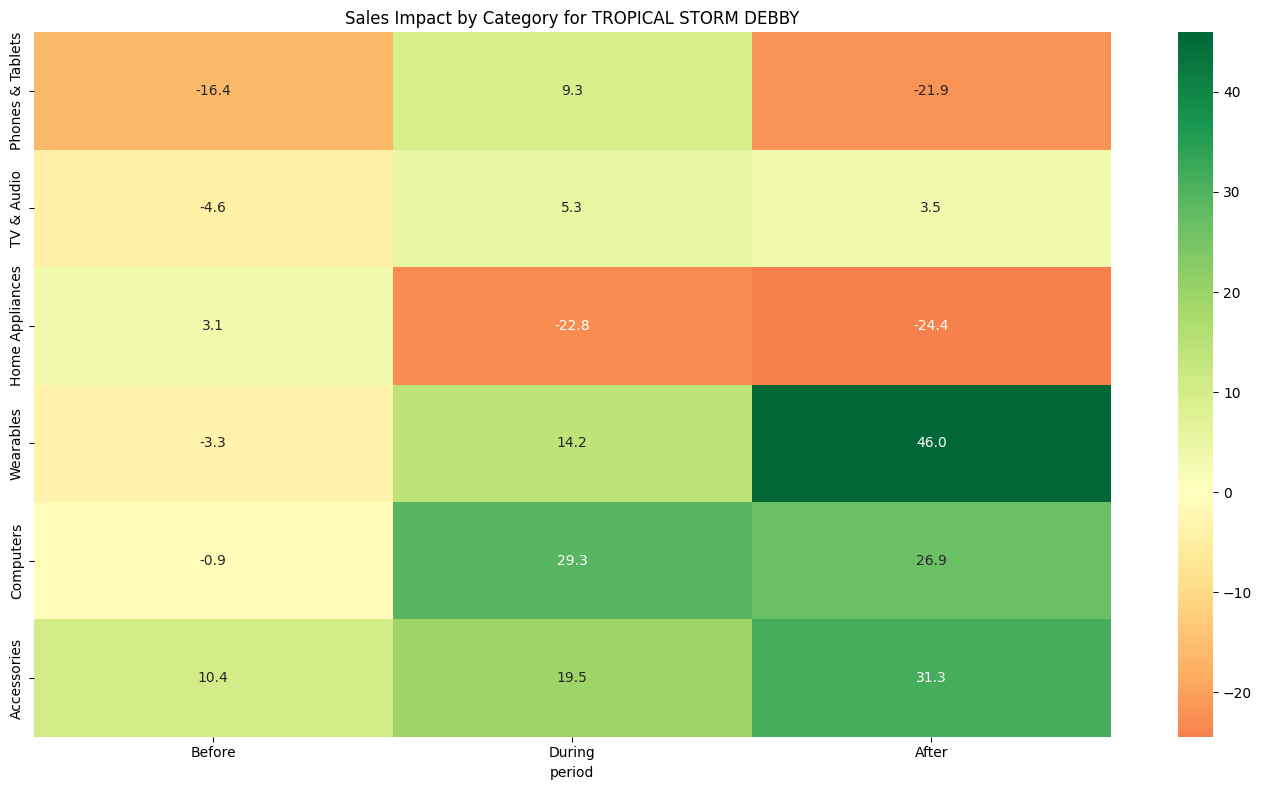


Comparing sales by category in impacted vs. control areas over time...


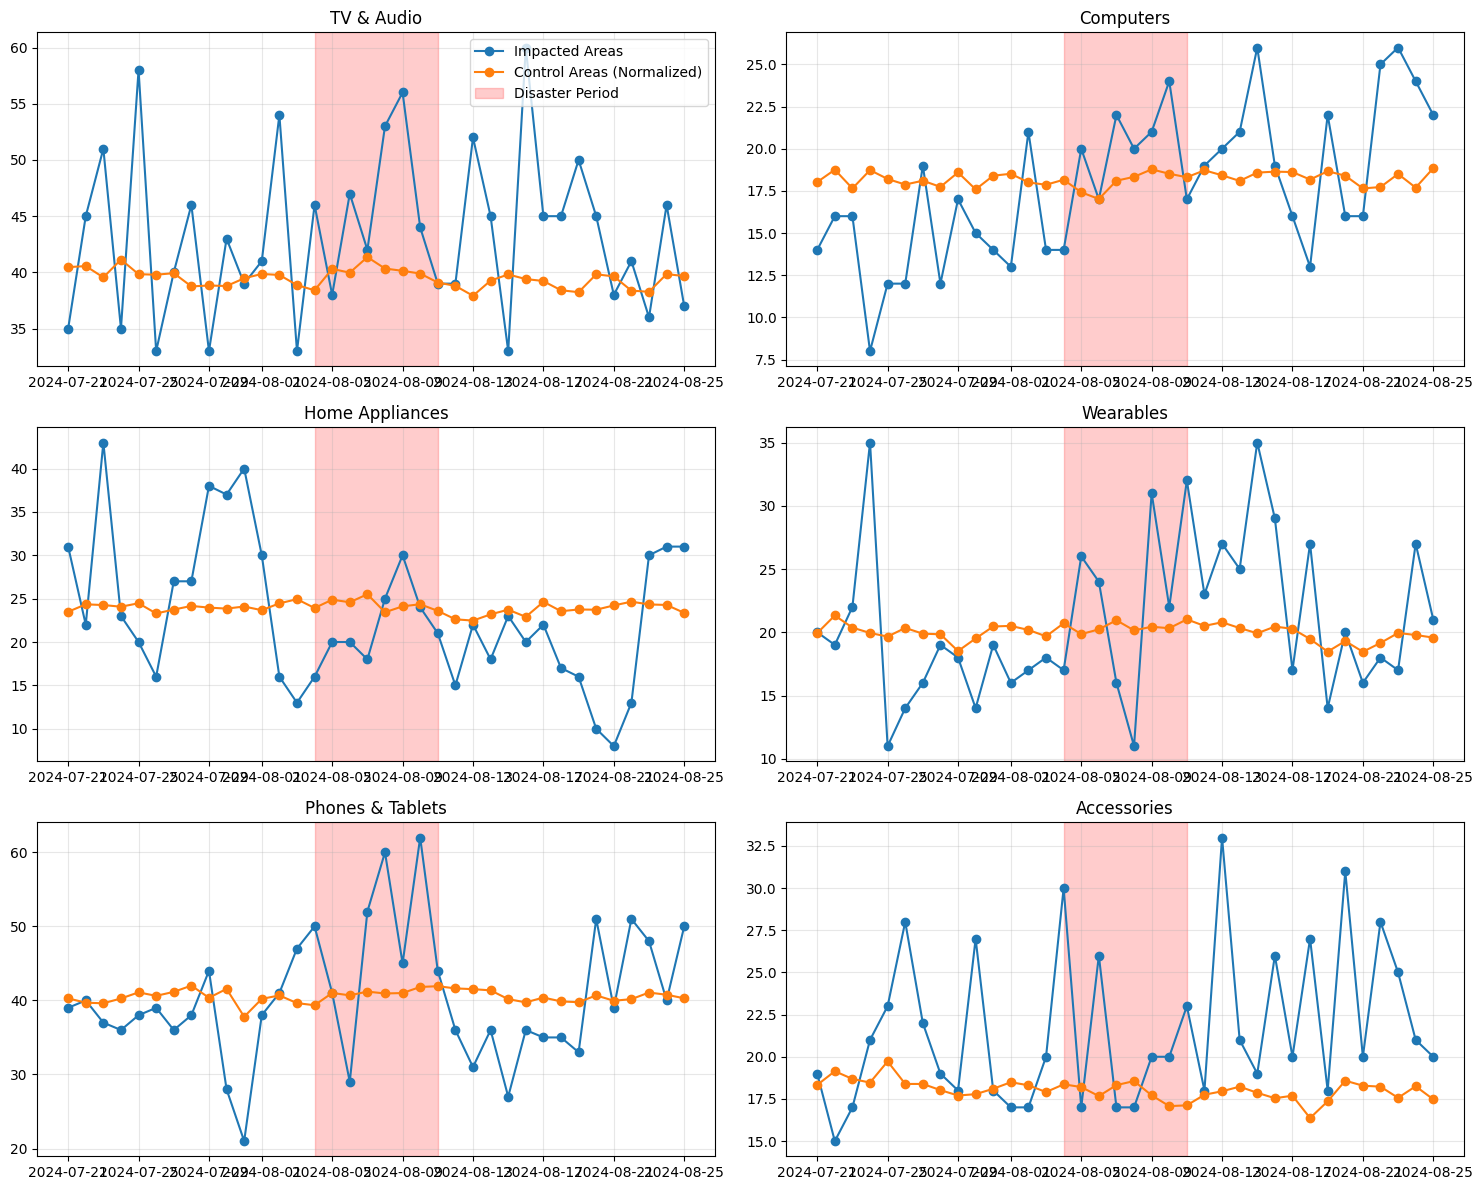


Analyzing inventory impact...


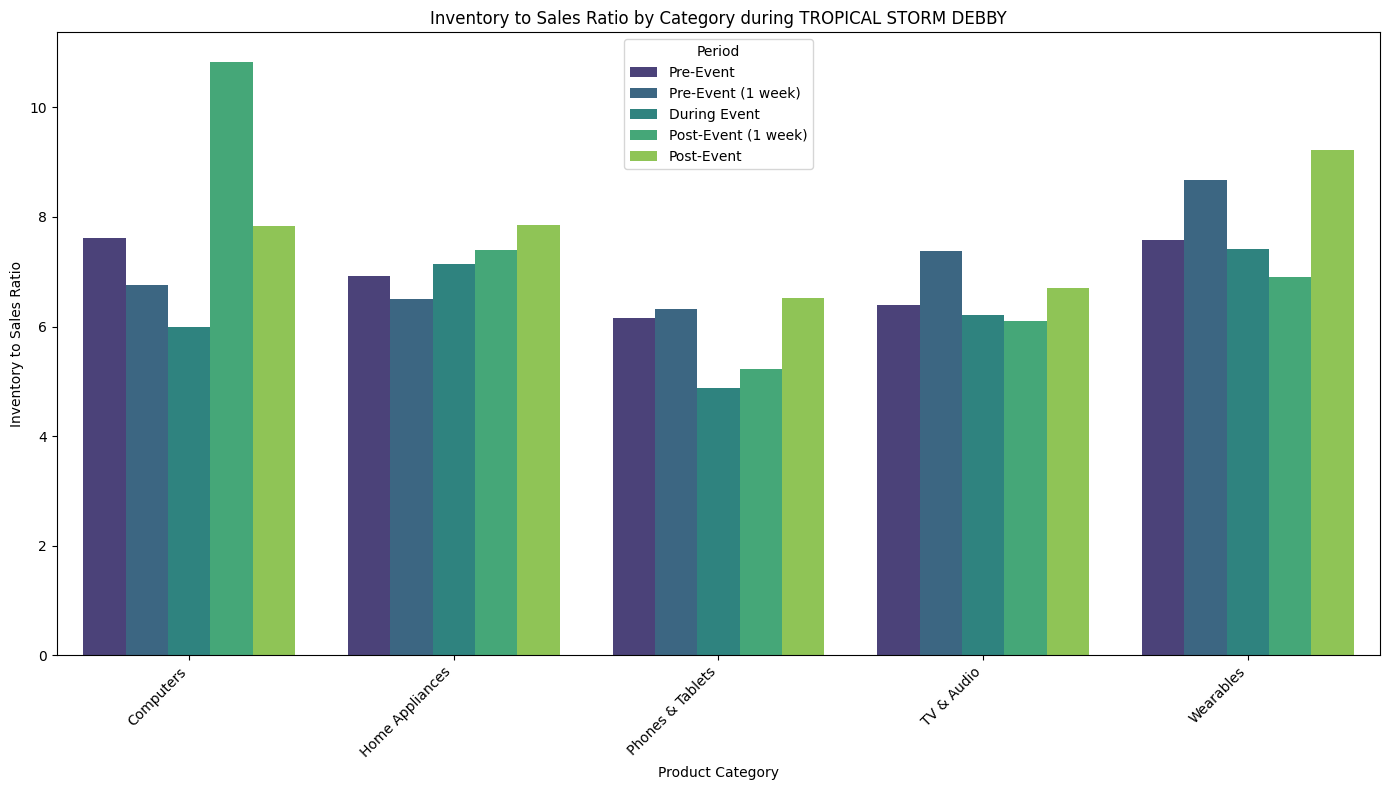


Generating strategic inventory recommendations...

ANALYSIS SUMMARY FOR TROPICAL STORM DEBBY
Analysis based on data from 2105 impacted zip codes
Disaster period: 2024-08-04 to 2024-08-11


,Category,Before_pct_change,During_pct_change,After_pct_change,Before_volume_lift_per_store,During_volume_lift_per_store,After_volume_lift_per_store
0,Wearables,-3.34,14.25,45.95,-0.32,1.37,4.43
1,Phones & Tablets,-16.36,9.27,-21.92,-3.39,1.92,-4.54
2,Home Appliances,3.06,-22.80,-24.44,0.37,-2.76,-2.96
3,Computers,-0.92,29.29,26.87,-0.08,2.65,2.43
4,TV & Audio,-4.55,5.26,3.52,-0.9,1.04,0.7
5,Accessories,10.39,19.51,31.28,0.9,1.69,2.72


In [14]:
# Run the Analysis
# Main dashboard with overall impact analysis
print("Generating Disaster Impact Dashboard")
create_disaster_dashboard(disaster_name="TROPICAL STORM DEBBY")